# Assignment 3 — Association Rule Mining

**Dataset:** `bread_basket.csv` (11569 transactions)

Fill in the short answer cells and run the code cells. This notebook generates the required tables and figures.

**Sections:**
1. Setup & Data Load
2. EDA (a–e)
3. Frequent Itemset Mining (FP-Growth)
4. Association Rules + Report Table
5. Rule Subgraph (Bread, Coffee, Cake, Tea)
6. Interpretation Prompt


## 1) Setup & Data Load (10 pts)
- Place `bread_basket.csv` in the same folder as this notebook **or** update the path below.
- Needed packages: `pandas`, `matplotlib`, `mlxtend`, `networkx` (for the small graph).
- If a package is missing, run the `pip install` cell.

In [99]:
# write your answer here
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend as mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

# Load the dataset
data = pd.read_csv('bread_basket.csv')
data.head()

,transaction,item,date_time,time,period_day,weekday_weekend
0,1,Bread,30/10/2016,9:58,morning,weekend
1,2,Scandinavian,30/10/2016,10:05,morning,weekend
2,2,Scandinavian,30/10/2016,10:05,morning,weekend
3,3,Hot chocolate,30/10/2016,10:07,morning,weekend
4,3,Jam,30/10/2016,10:07,morning,weekend


In [100]:
data.shape # to display the number of rows and columns in the dataset, which gives an overview of the dataset's size and structure.

(20507, 6)

In [101]:
data.isnull().sum() # to check for any missing values in the dataset by summing the number of null values in each column, which helps identify if there are any incomplete records that may need to be addressed before analysis.

transaction        0
item               0
date_time          0
time               0
period_day         0
weekday_weekend    0
dtype: int64

## 2) EDA (a–e) (30 pts)
### a) List variables and their dtypes (5 pts)

In [3]:
# write your answer here
print(data.dtypes) # to check the data types of each column in the dataset, which can help identify if any columns need to be converted to the appropriate type for analysis.

transaction         int64
item               object
date_time          object
time               object
period_day         object
weekday_weekend    object
dtype: object


### b) "Statistics" overview (5 pts)
Use `describe(include='all')` as a stand‑in for RapidMiner's Statistics. Take a screenshot when you submit.

In [4]:
# write your answer here
print(data.describe(include='all')) # to get a summary of the dataset, including counts, unique values, top values, and frequency for categorical columns.


         transaction    item   date_time   time period_day weekday_weekend
count   20507.000000   20507       20507  20507      20507           20507
unique           NaN      94         159   1255          4               2
top              NaN  Coffee  2017-02-04  11:06  afternoon         weekday
freq             NaN    5471         292     52      11569           12807
mean     4976.202370     NaN         NaN    NaN        NaN             NaN
std      2796.203001     NaN         NaN    NaN        NaN             NaN
min         1.000000     NaN         NaN    NaN        NaN             NaN
25%      2552.000000     NaN         NaN    NaN        NaN             NaN
50%      5137.000000     NaN         NaN    NaN        NaN             NaN
75%      7357.000000     NaN         NaN    NaN        NaN             NaN
max      9684.000000     NaN         NaN    NaN        NaN             NaN


### c) Bar plot — count of **unique transactions per item** (10 pts)
Set the subtitle to your **FirstName LastName**. Take a screenshot of the figure.

In [31]:
print("the total number of transactions is:", data["transaction"].nunique(), end = "\n\n") # to find the total number of unique transactions in the dataset by counting the unique values in the 'transaction' column.
data['transaction'].value_counts(normalize = True).head() # to display the top 5 most frequent transactions in the dataset by counting the occurrences of each unique value in the 'transaction' column and displaying the top 5.

the total number of transactions is: 9465



transaction
6716    0.000536
6279    0.000536
6474    0.000536
6412    0.000536
6045    0.000488
Name: proportion, dtype: float64

In [33]:
print("the total number of unique items is:", data["item"].nunique(), end = "\n\n") # to find the total number of unique items in the dataset by counting the unique values in the 'item' column.
data['item'].value_counts(normalize = True).head() # to display the top 5 most frequent items in the dataset by counting the occurrences of each unique value in the 'item' column and displaying the top 5.

the total number of unique items is: 94



item
Coffee    0.266787
Bread     0.162140
Tea       0.069976
Cake      0.049983
Pastry    0.041742
Name: proportion, dtype: float64

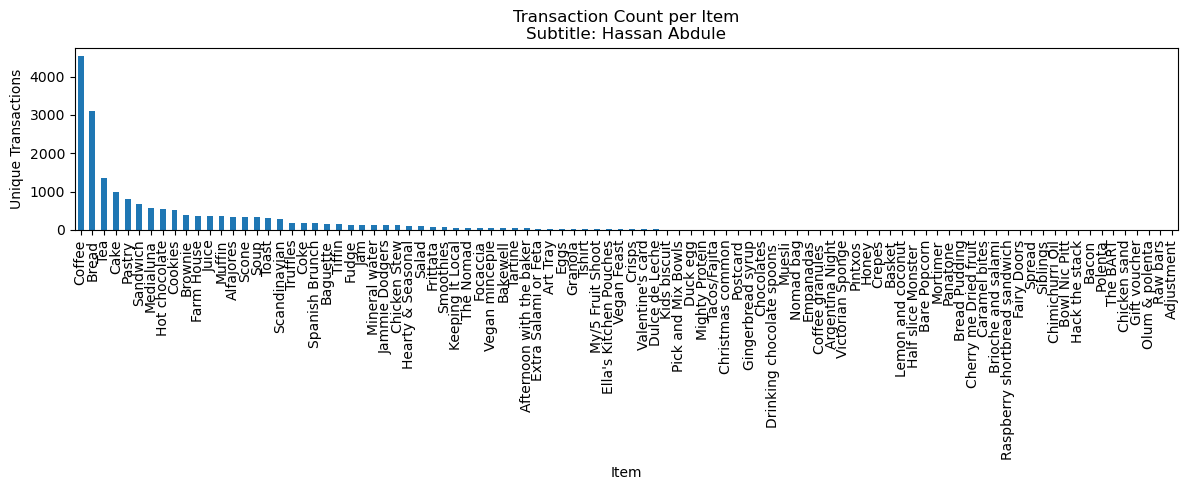

In [ ]:
# c) Bar plot of transaction counts per item
# subtitle = " "  # <-- EDIT THIS
# item_counts =  # <-- EDIT THIS

item_counts = (
    data.groupby('item')['transaction'].nunique().sort_values(ascending=False))
ax = item_counts.plot(kind='bar', figsize=(12,5))
subtitle = 'Hassan Abdule'
plt.title(f"Transaction Count per Item\nSubtitle: {subtitle}")
plt.xlabel("Item"); plt.ylabel("Unique Transactions")
plt.tight_layout()
plt.show()

### d) Report counts for Coffee, Tea, Alfajores, Juice, and Chicken Stew (10 pts)


In [ ]:
# write your answer here
items_of_interest = ['Coffee', 'Tea', 'Alfajores', 'Juice', 'Chicken Stew']
for item in items_of_interest: # Loop through the items of interest
    count = item_counts.get(item, 0)  # Get the count for the items
    print(f"{item}: {count} unique transactions") # Print the count for each item of interest, using get to handle cases where the item might not be present in the dataset.


Coffee: 4528 unique transactions
Tea: 1350 unique transactions
Alfajores: 344 unique transactions
Juice: 365 unique transactions
Chicken Stew: 123 unique transactions


## 3) Frequent Itemset Mining with FP‑Growth (min_support = 0.2) (20 pts)
We pivot the data to a **transaction × item** one‑hot table (boolean), then run FP‑Growth.

In [96]:
# write your answer here
from mlxtend.frequent_patterns import fpgrowth # import the fpgrowth algorithm from mlxtend.frequent_patterns
basket = (data.groupby(['transaction', 'item'])['item'].count().unstack().fillna(0))  # create a basket matrix where rows represent transactions and columns represent items
def basket_encoding(x): # define a function to encode the basket matrix into a binary format (1 if the item is present in the transaction, 0 if not)
    if x <= 0:
        return 0
    else:
        return 1
basket = basket.applymap(basket_encoding) # apply the encoding function to each element of the basket matrix using applymap, which applies the function element-wise to the entire DataFrame3
basket = basket.astype('bool') # convert the basket matrix to boolean type, which is required for the fpgrowth algorithm
    
frequent_itemsets = fpgrowth(basket, min_support=0.2, use_colnames=True) # apply the fpgrowth algorithm to find frequent itemsets with a minimum support of 0.2, and use_colnames=True to return the item names instead of column indices
print(frequent_itemsets) # and just print to the computer 





    support  itemsets
0  0.327205   (Bread)
1  0.478394  (Coffee)


/var/folders/6t/5p6s6gpx41qgd4jpmhvw1s9h0000gn/T/ipykernel_55641/2470212051.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(basket_encoding) # apply the encoding function to each element of the basket matrix using applymap, which applies the function element-wise to the entire DataFrame3


In [59]:
cake_support = basket['Cake'].sum() / basket.shape[0]
cake_support   # to display the percentage support for 'Cake' in the basket matrix, which shows the binary encoding of items in transactions.

np.float64(0.10385631273111463)

In [ ]:
cake_support = basket['Coffee'].sum() / basket.shape[0] # to calculate the support for 'Coffee' in the basket matrix by summing the values in the 'Coffee' column (which counts how many transactions contain 'Coffee') and dividing by the total number of transactions (the number of rows in the basket matrix) to get the support as a percentage.
cake_support 

np.float64(0.47839408346539886)

In [95]:
cake_support = basket['Bread'].sum() / basket.shape[0] # to calculate the support for 'Bread' in the basket matrix by summing the values in the 'Bread' column (which counts how many transactions contain 'Bread') and dividing by the total number of transactions (the number of rows in the basket matrix) to get the support as a percentage.
cake_support 

np.float64(0.32720549392498677)

In [94]:
triple_support = (basket['Coffee'] & basket['Cake'] & basket['Bread']).sum() / basket.shape[0]
triple_support * 100 # to calculate the support for the combination of 'Coffee', 'Cake', and 'Bread' by performing a logical AND operation on the corresponding columns in the basket matrix, summing the resulting boolean values to count how many transactions contain all three items, and then dividing by the total number of transactions to get the support as a percentage. 

np.float64(1.0036978341257263)

## 4) Association Rules + Report Table (30 pts)
(metric = confidence, min_threshold = ?) Please find a suitable min_threshold

In [93]:
# write your answer here
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7) # generate association rules from the frequent itemsets using confidence as the metric and a minimum threshold of 0.7
rules = rules.sort_values(by = 'lift', ascending = False) # sort the generated association rules by the 'Lift' metric in descending order to show the most interesting rules at the top.
print(rules.head(20)) # print the generated association rules, sorted by the 'Lift' metric in descending order to show the most interesting rules at the top.



Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


## 5) Interpretation (10 pts)
**Interpret the rule `{Coffee, Cake} ⇒ {Bread}` in plain English.**

- **Support**: What fraction of *all* transactions contain Coffee, Cake, and Bread together?
- **Confidence**: Among baskets with Coffee and Cake, what share also include Bread?
- **Lift > 1** implies positive association; comment on practical meaning.

*Your notes:* (write your answer here)

> 

For FP-Growth, I got support values of 0.478 for Coffee and 0.327 for Bread. My understanding is that this means about 47.8% of all transactions include Coffee and about 32.7% include Bread. For Cake, the support is 0.1038, which means Cake appears in about 10.38% of transactions.

For the combination of Coffee, Cake, and Bread together, the support is about 0.0100, which is about 1.00% of all transactions.

If lift is greater than 1, it means customers who buy Coffee and Cake are more likely than average to also buy Bread.


